# BIG MART SALES PREDICTION

This is a challenge posted on Analytics Vidhya (link: https://datahack.analyticsvidhya.com/contest/practice-problem-big-mart-sales-iii/#ProblemStatement)

   **Project Description:** 

   The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and predict the sales of each product at a particular outlet.

Using this model, BigMart will try to understand the properties of products and outlets which play a key role in increasing sales.

   Here is a description of all the columns in the dataset:

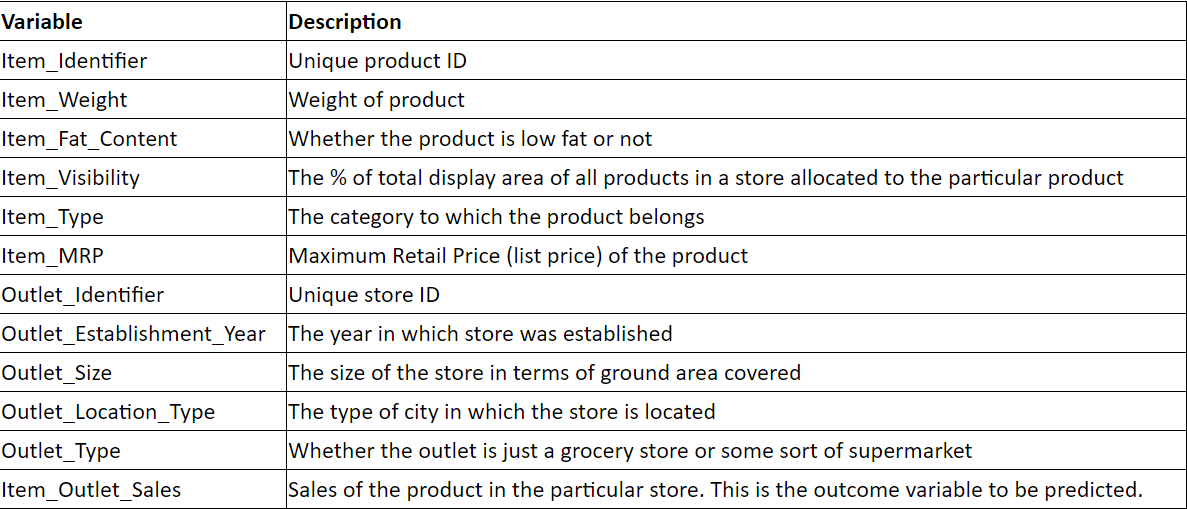

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno

In [2]:
from sklearn.impute import KNNImputer

# READ IN THE DATA

In [3]:
train = pd.read_csv("train_big.csv")

In [4]:
pd.set_option("display.max_columns", None)
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [6]:
train.shape

(8523, 12)

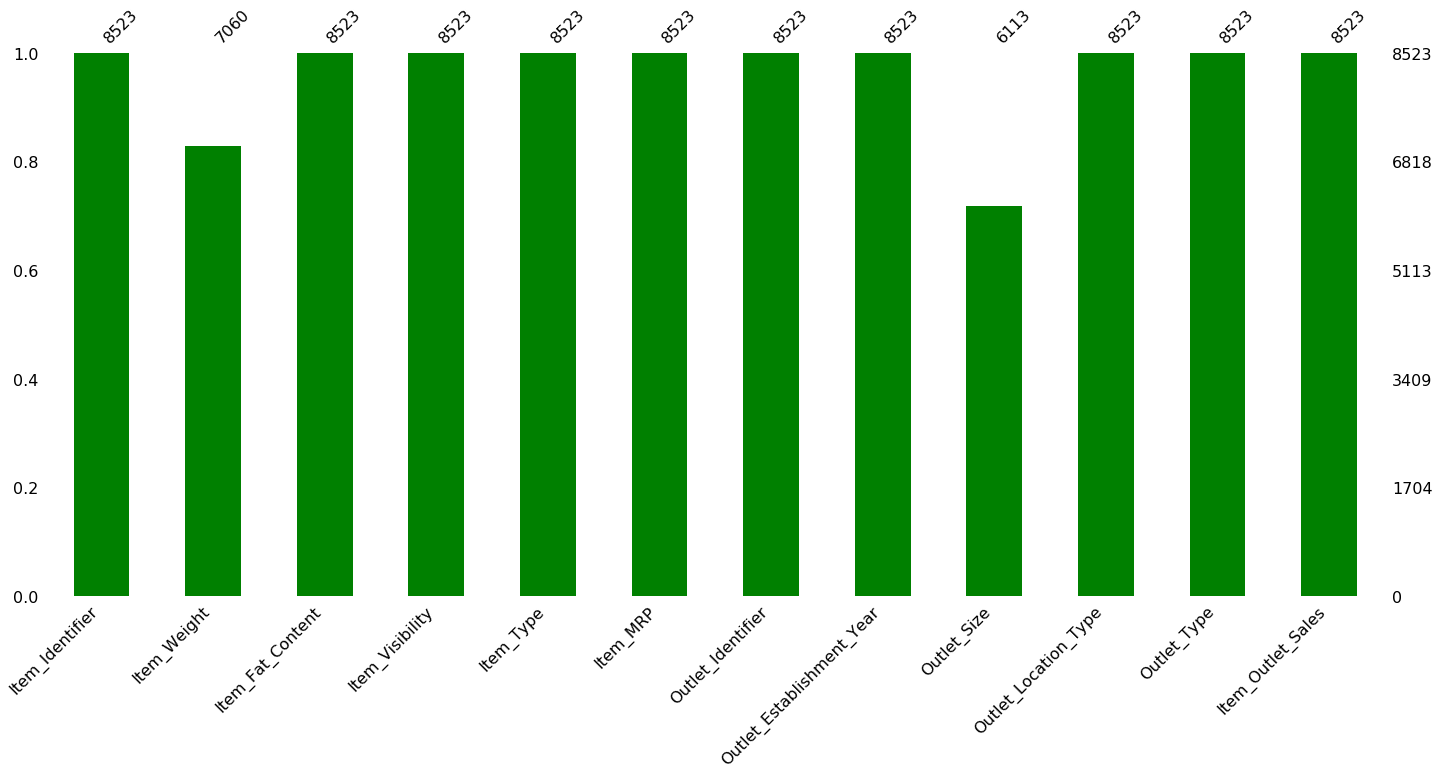

In [7]:
msno.bar(train, color = 'green')

In [8]:
train.isnull().sum().sort_values(ascending=False)

Outlet_Size                  2410
Item_Weight                  1463
Item_Outlet_Sales               0
Outlet_Type                     0
Outlet_Location_Type            0
Outlet_Establishment_Year       0
Outlet_Identifier               0
Item_MRP                        0
Item_Type                       0
Item_Visibility                 0
Item_Fat_Content                0
Item_Identifier                 0
dtype: int64

# DATA MANIPULATION

In [9]:
# get rid of the columns we don't need

train.drop(['Item_Identifier', 'Outlet_Identifier'],axis=1, inplace = True)

In [10]:
train['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

From the above we see that there are actually only two categories in 'Item_Fat_Content': low fat and regular, which are written in different ways. Let's map those values to make them consistent. 

In [11]:
mapping_1 = {'Low Fat': 'Low Fat', 'Regular': 'Regular','LF': 'Low Fat', 'reg': 'Regular', 'low fat': 'Low Fat'}

train['Item_Fat_Content']=train['Item_Fat_Content'].map(mapping_1)

Now, let's find duplicated data (if any) and drop it for the purposes of our analysis. 

In [12]:
train[train.duplicated()] 

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales


Good - no duplicates found! We will deal with outliers later, after we impute the missing data.

Before we start exploring the data (plotting correlations, understanding the relationships between features, etc.), it would be good to label_encode / one-hot-encode the features with 'object' data type (*'Item_Fat_Content', 'Item_Type', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'*), and after that, we will need to handle the missing values in 'Outlet Size' and 'Item Weight'.
    
   We can use K-nearest neighbors algorithm to impute the missing values for columns 'Outlet Size' and 'Item Weight'. This algorithm will find the k closest neighbors to the observation with null values and then will impute those values with the mean value of the closest neighbors. This is a reasonable choice considering that we have a dataset of products amongst which some will most likely be similar in values.

In [13]:
# let's label encode features with binary/ordinal values - i.e. 'Item_Fat_Content' and 'Outlet_Size'

mapping_2 = {'Low Fat': 0, 'Regular': 1}
mapping_3 = {'High': 2, 'Medium': 1, 'Small': 0, np.nan:np.nan}

train['Item_Fat_Content'] = train['Item_Fat_Content'].map(mapping_2)
train['Outlet_Size'] = train['Outlet_Size'].map(mapping_3)


In [14]:
train['Outlet_Size'].value_counts(dropna=False)

1.0    2793
NaN    2410
0.0    2388
2.0     932
Name: Outlet_Size, dtype: int64

In [15]:
# let's one hot encode the rest of the categorical features

train_enc  = pd.get_dummies(train, columns = ['Item_Type', 'Outlet_Location_Type', 'Outlet_Type'])

In [16]:
train_enc.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Item_Outlet_Sales,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,9.30,0,0.016047,249.8092,1999,1.0,3735.1380,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
1,5.92,1,0.019278,48.2692,2009,1.0,443.4228,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0
2,17.50,0,0.016760,141.6180,1999,1.0,2097.2700,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
3,19.20,1,0.000000,182.0950,1998,NaN,732.3800,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
4,8.93,0,0.000000,53.8614,1987,2.0,994.7052,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0


In [17]:
# impute the missing values with KNN

imputer = KNNImputer() # leave n_neighbors as default for now

train_filled = imputer.fit_transform(train_enc)

In [18]:
train_restated = pd.DataFrame(train_filled,columns = train_enc.columns)

In [19]:
train_restated.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Item_Outlet_Sales,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,9.30,0.0,0.016047,249.8092,1999.0,1.0,3735.1380,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,5.92,1.0,0.019278,48.2692,2009.0,1.0,443.4228,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,17.50,0.0,0.016760,141.6180,1999.0,1.0,2097.2700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,19.20,1.0,0.000000,182.0950,1998.0,0.4,732.3800,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,8.93,0.0,0.000000,53.8614,1987.0,2.0,994.7052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


We can see a value of 0.4 in row 3, column 'Outlet_Size' of the imputed dataset - since this feature is ordinal, it is supposed to take on the values of 0, 1 or 2 - so, let's apply rounding. 

In [22]:
train_restated['Outlet_Size']=train_restated['Outlet_Size'].astype(int)

In [23]:
train_restated['Outlet_Size'].value_counts()

0    4511
1    3080
2     932
Name: Outlet_Size, dtype: int64

# DATA EXPLORATION

[Text(0, 0, 'Supermarket Type1'),
 Text(0, 0, 'Supermarket Type2'),
 Text(0, 0, 'Grocery Store'),
 Text(0, 0, 'Supermarket Type3')]

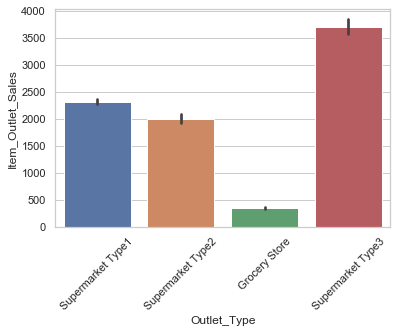

In [39]:
sns.set(style="whitegrid")
ax = sns.barplot(x="Outlet_Type", y="Item_Outlet_Sales", data=train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

[Text(0, 0, 'Dairy'),
 Text(0, 0, 'Soft Drinks'),
 Text(0, 0, 'Meat'),
 Text(0, 0, 'Fruits and Vegetables'),
 Text(0, 0, 'Household'),
 Text(0, 0, 'Baking Goods'),
 Text(0, 0, 'Snack Foods'),
 Text(0, 0, 'Frozen Foods'),
 Text(0, 0, 'Breakfast'),
 Text(0, 0, 'Health and Hygiene'),
 Text(0, 0, 'Hard Drinks'),
 Text(0, 0, 'Canned'),
 Text(0, 0, 'Breads'),
 Text(0, 0, 'Starchy Foods'),
 Text(0, 0, 'Others'),
 Text(0, 0, 'Seafood')]

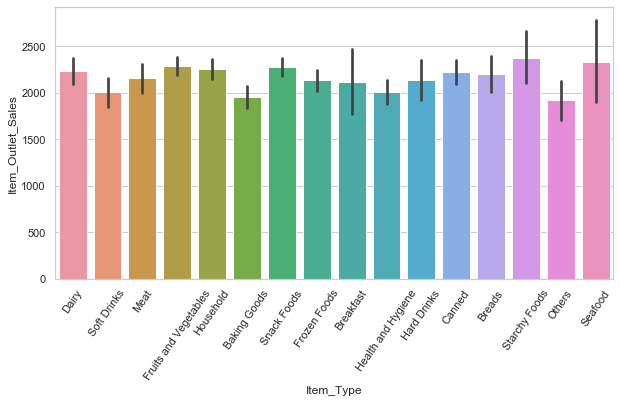

In [46]:
plt.figure(figsize=(10,5))
sns.set(style="whitegrid")
ax = sns.barplot(x="Item_Type", y="Item_Outlet_Sales", data=train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=55)

The highest sales were achieved in supermarket type 3, followed by supermarket type 1 - could this be driven by the location of the supermarket?

Products with the highest sales are dairy,meat, fruits & vegetables, household, snacks, starchy foods and seafood.

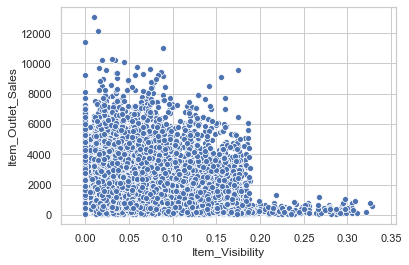

In [54]:
sns.scatterplot(x='Item_Visibility',y='Item_Outlet_Sales',data=train)

No clear relationship identified.

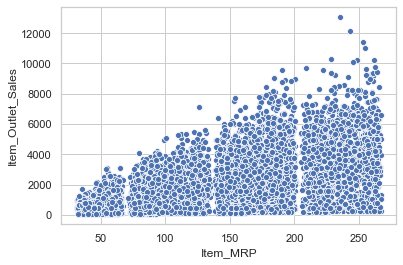

In [57]:
sns.scatterplot(x='Item_MRP',y='Item_Outlet_Sales',data=train)

Clearly, higher item retail prices contribute to higher item sales - plus, we can see some outliers in the data.

[Text(0, 0, 'Tier 1'), Text(0, 0, 'Tier 3'), Text(0, 0, 'Tier 2')]

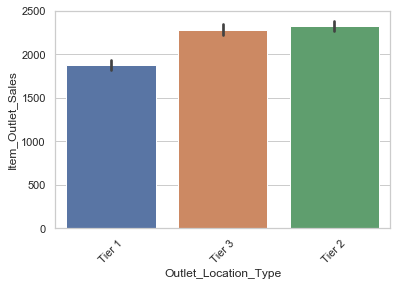

In [59]:
ax = sns.barplot(x="Outlet_Location_Type", y="Item_Outlet_Sales", data=train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

Tier 2 and 3 contribute to higher sales, which might be driven by a more favorable location of the stores. 

[Text(0, 0, '1985'),
 Text(0, 0, '1987'),
 Text(0, 0, '1997'),
 Text(0, 0, '1998'),
 Text(0, 0, '1999'),
 Text(0, 0, '2002'),
 Text(0, 0, '2004'),
 Text(0, 0, '2007'),
 Text(0, 0, '2009')]

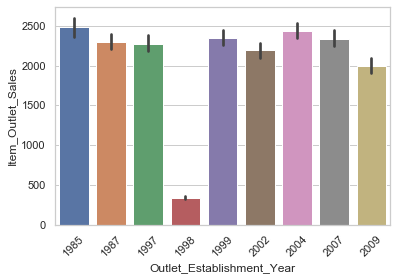

In [62]:
ax = sns.barplot(x="Outlet_Establishment_Year", y="Item_Outlet_Sales", data=train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

The lowest sales were achieved by the outlets established in 1998 - let's see what type of outlets they are:

In [64]:
train[train['Outlet_Establishment_Year']==1998]['Outlet_Type'].unique()

array(['Grocery Store'], dtype=object)

[Text(0, 0, 'Dairy'),
 Text(0, 0, 'Soft Drinks'),
 Text(0, 0, 'Meat'),
 Text(0, 0, 'Fruits and Vegetables'),
 Text(0, 0, 'Household'),
 Text(0, 0, 'Baking Goods'),
 Text(0, 0, 'Snack Foods'),
 Text(0, 0, 'Frozen Foods'),
 Text(0, 0, 'Breakfast'),
 Text(0, 0, 'Health and Hygiene'),
 Text(0, 0, 'Hard Drinks'),
 Text(0, 0, 'Canned'),
 Text(0, 0, 'Breads'),
 Text(0, 0, 'Starchy Foods'),
 Text(0, 0, 'Others'),
 Text(0, 0, 'Seafood')]

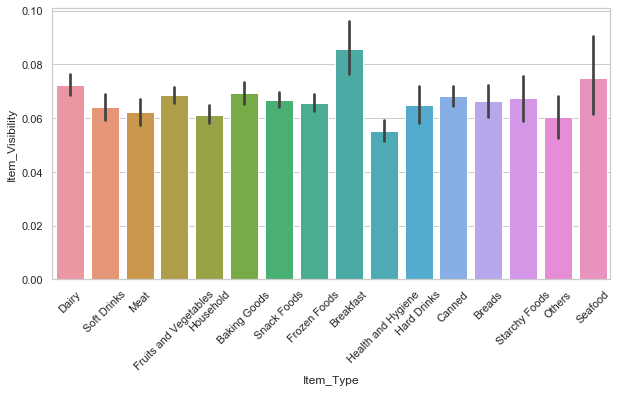

In [68]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x="Item_Type", y="Item_Visibility", data=train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

Looks like breakfast, seafood and dairy items are the most visible.

[Text(0, 0, 'Tier 1'), Text(0, 0, 'Tier 3'), Text(0, 0, 'Tier 2')]

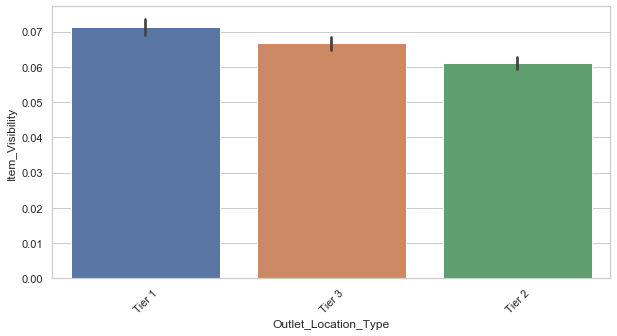

In [70]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x="Outlet_Location_Type", y="Item_Visibility", data=train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

The highest item visibility is in tier 1, but as we saw item visibility does not have a clear relationship with sales.

# PLOT CORRELATIONS

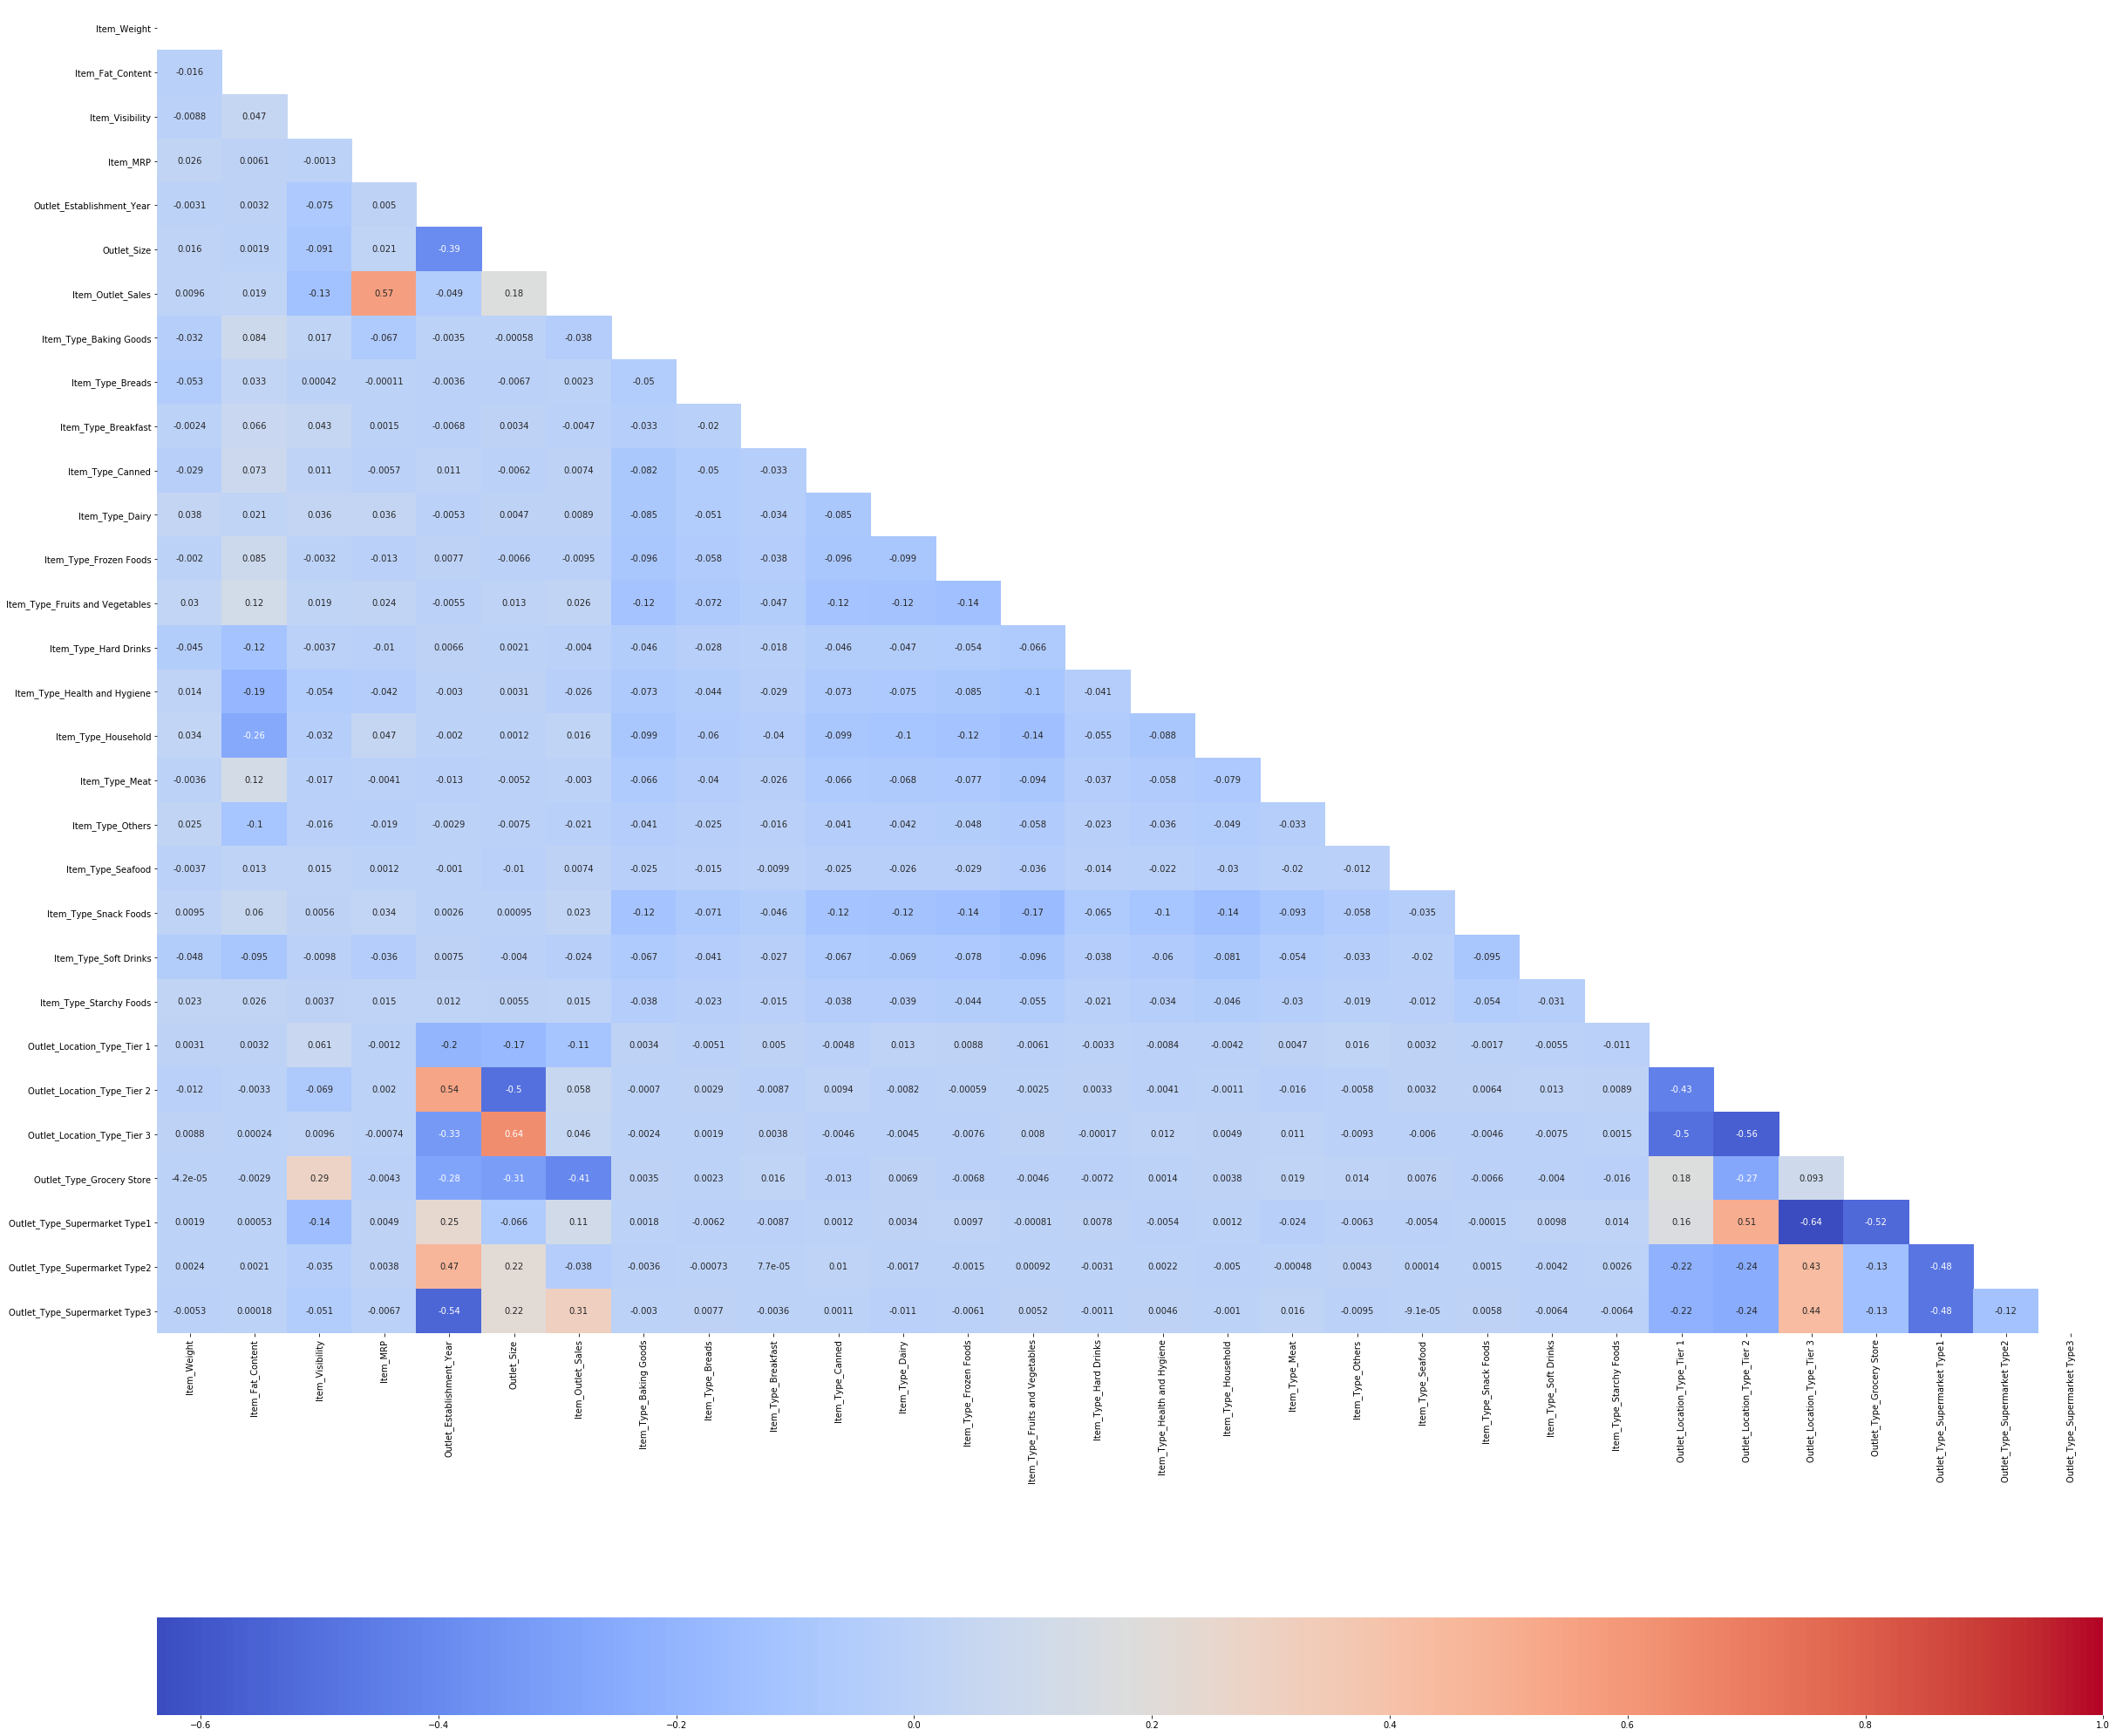

In [26]:
corr_matrix = np.triu(train_restated.corr())

plt.figure(figsize=(40,40))

sns.heatmap(train_restated.corr(), cmap ='coolwarm', annot = True, fmt='.2g', cbar_kws= {'orientation': 'horizontal'}, mask=corr_matrix)

In [28]:
train_restated.corr()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Item_Outlet_Sales,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
Item_Weight,1.000000,-0.016481,-0.008787,0.025529,-0.003110,0.015521,0.009576,-0.032097,-0.053296,-0.002444,-0.028562,0.037857,-0.001956,0.030175,-0.044844,0.014432,0.034026,-0.003605,0.025058,-0.003717,0.009540,-0.047616,0.023077,0.003104,-0.012093,0.008759,-0.000042,0.001912,0.002417,-0.005274
Item_Fat_Content,-0.016481,1.000000,0.047314,0.006063,0.003151,0.001910,0.018719,0.083804,0.032643,0.065711,0.073235,0.021236,0.085041,0.116955,-0.118461,-0.188156,-0.255203,0.118574,-0.104988,0.012594,0.059848,-0.094875,0.025945,0.003155,-0.003272,0.000241,-0.002924,0.000533,0.002129,0.000183
Item_Visibility,-0.008787,0.047314,1.000000,-0.001315,-0.074834,-0.091278,-0.128625,0.016887,0.000416,0.043418,0.011114,0.035984,-0.003153,0.018969,-0.003700,-0.053931,-0.032230,-0.017087,-0.016240,0.014910,0.005635,-0.009825,0.003688,0.061346,-0.068787,0.009650,0.286400,-0.144249,-0.034671,-0.051144
Item_MRP,0.025529,0.006063,-0.001315,1.000000,0.005020,0.021460,0.567574,-0.067311,-0.000112,0.001460,-0.005666,0.035551,-0.013358,0.023688,-0.010089,-0.041646,0.046815,-0.004086,-0.018595,0.001186,0.033817,-0.035808,0.014613,-0.001229,0.001951,-0.000744,-0.004277,0.004885,0.003850,-0.006714
Outlet_Establishment_Year,-0.003110,0.003151,-0.074834,0.005020,1.000000,-0.392070,-0.049135,-0.003546,-0.003631,-0.006768,0.010998,-0.005286,0.007690,-0.005495,0.006627,-0.002961,-0.001951,-0.013428,-0.002874,-0.001013,0.002650,0.007486,0.011897,-0.201690,0.540820,-0.333895,-0.281196,0.245070,0.466336,-0.538072
Outlet_Size,0.015521,0.001910,-0.091278,0.021460,-0.392070,1.000000,0.179534,-0.000580,-0.006736,0.003350,-0.006161,0.004698,-0.006629,0.013419,0.002055,0.003143,0.001190,-0.005179,-0.007468,-0.010244,0.000946,-0.003983,0.005480,-0.174922,-0.498717,0.639743,-0.311515,-0.065709,0.215885,0.216797
Item_Outlet_Sales,0.009576,0.018719,-0.128625,0.567574,-0.049135,0.179534,1.000000,-0.038381,0.002332,-0.004656,0.007387,0.008858,-0.009482,0.025950,-0.003956,-0.025587,0.015701,-0.002995,-0.021267,0.007380,0.022782,-0.024040,0.015039,-0.111287,0.058261,0.046376,-0.411727,0.108765,-0.038059,0.311192
Item_Type_Baking Goods,-0.032097,0.083804,0.016887,-0.067311,-0.003546,-0.000580,-0.038381,1.000000,-0.049968,-0.032801,-0.082354,-0.084600,-0.095849,-0.117916,-0.046036,-0.073120,-0.099176,-0.065715,-0.040800,-0.024951,-0.116120,-0.067327,-0.038133,0.003392,-0.000701,-0.002446,0.003536,0.001846,-0.003632,-0.002957
Item_Type_Breads,-0.053296,0.032643,0.000416,-0.000112,-0.003631,-0.006736,0.002332,-0.049968,1.000000,-0.019918,-0.050010,-0.051373,-0.058204,-0.071605,-0.027955,-0.044402,-0.060225,-0.039906,-0.024776,-0.015152,-0.070514,-0.040885,-0.023156,-0.005140,0.002933,0.001909,0.002305,-0.006189,-0.000734,0.007693
Item_Type_Breakfast,-0.002444,0.065711,0.043418,0.001460,-0.006768,0.003350,-0.004656,-0.032801,-0.019918,1.000000,-0.032828,-0.033723,-0.038207,-0.047004,-0.018351,-0.029147,-0.039533,-0.026195,-0.016264,-0.009946,-0.046288,-0.026838,-0.015201,0.005046,-0.008741,0.003754,0.015676,-0.008695,0.000077,-0.003550
